In [ ]:
#套件讀取
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy.stats import norm,skew #常態分布
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance

In [ ]:
#Google雲端
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#讀取data
data_train = pd.read_csv("/content/drive/MyDrive/regression_hw/train-v3.csv")
data_test = pd.read_csv("/content/drive/MyDrive/regression_hw/test-v3.csv")

In [ ]:
data_train.columns

Index(['id', 'price', 'sale_yr', 'sale_month', 'sale_day', 'bedrooms',
       'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

In [ ]:
data_train['price'].describe()

#屬性
#count 幾條紀錄"Data量
#mean 平均價格
#std 標準差
#min最小值
#max最大值
#25% 50% 75% 四分位數

count    1.296700e+04
mean     5.373833e+05
std      3.668840e+05
min      7.500000e+04
25%      3.199500e+05
50%      4.470000e+05
75%      6.370000e+05
max      7.062500e+06
Name: price, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


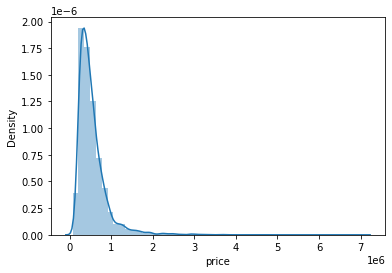

In [ ]:
sns.distplot(data_train['price']);

#尾巴在右 為右偏態

In [ ]:
print("Skewness: %f" % data_train['price'].skew())
print("Kurtosis: %f" % data_train['price'].kurt())

Skewness: 3.811544
Kurtosis: 28.924840


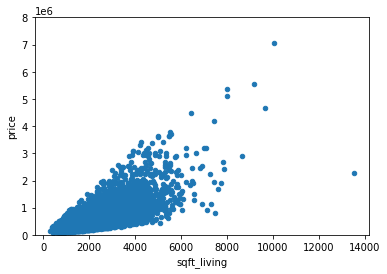

In [ ]:
var ='sqft_living'  #房屋面積
data = pd.concat([data_train['price'],data_train[var]], axis=1)
data.plot.scatter(x=var,y='price',ylim=(0,8000000));

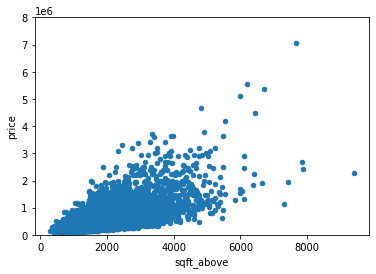

In [ ]:
var ='sqft_above' #除了地下室以外的面積
data = pd.concat([data_train['price'],data_train[var]], axis=1)
data.plot.scatter(x=var,y='price',ylim=(0,8000000));

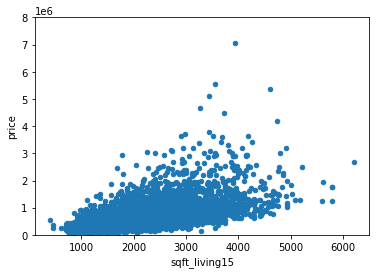

In [ ]:
var ='sqft_living15' #客廳面積
data = pd.concat([data_train['price'],data_train[var]], axis=1)
data.plot.scatter(x=var,y='price',ylim=(0,8000000));

(-0.5, 11.5, 0.0, 8000000.0)

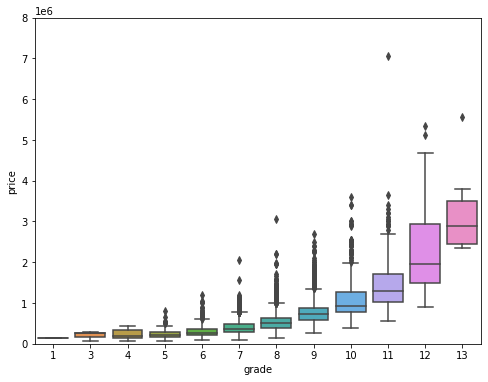

In [ ]:
#房屋整體等級
var='grade'
data = pd.concat([data_train['price'],data_train[var]],axis=1)
f,ax = plt.subplots(figsize=(8,6))
fig =sns.boxplot(x=var,y='price',data=data)
fig.axis(ymin=0,ymax=8000000)

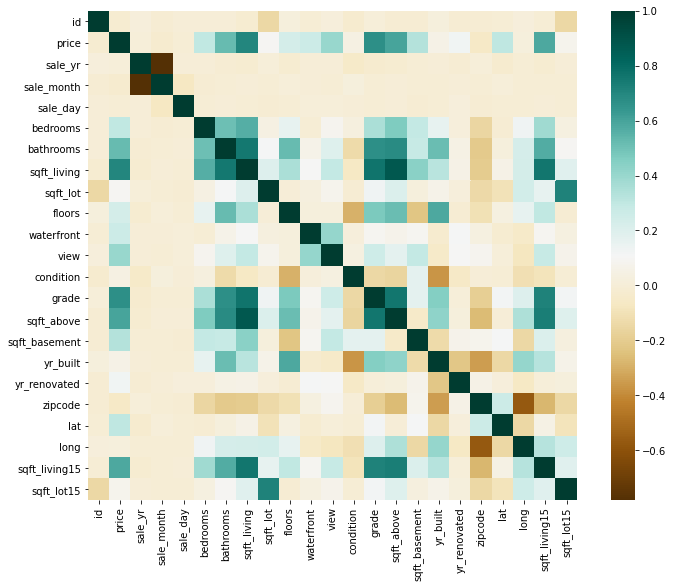

In [ ]:
#特徵相關性
corrmat = data_train.corr()
f,ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, square=True,cmap='BrBG')

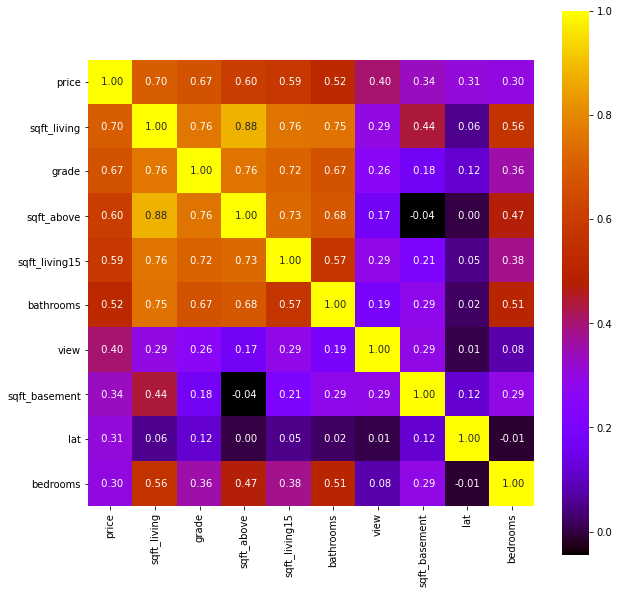

In [ ]:
k = 10 #選10個與價格最接近的特徵
cols =corrmat.nlargest(k,'price')['price'].index
cm = np.corrcoef(data_train[cols].values.T)
plt.subplots(figsize=(10,10))
hm = sns.heatmap(cm,cbar=True ,annot=True,square=True,fmt=' .2f',annot_kws={'size' : 10}, yticklabels =cols.values , xticklabels=cols.values ,cmap='gnuplot')
plt.show()

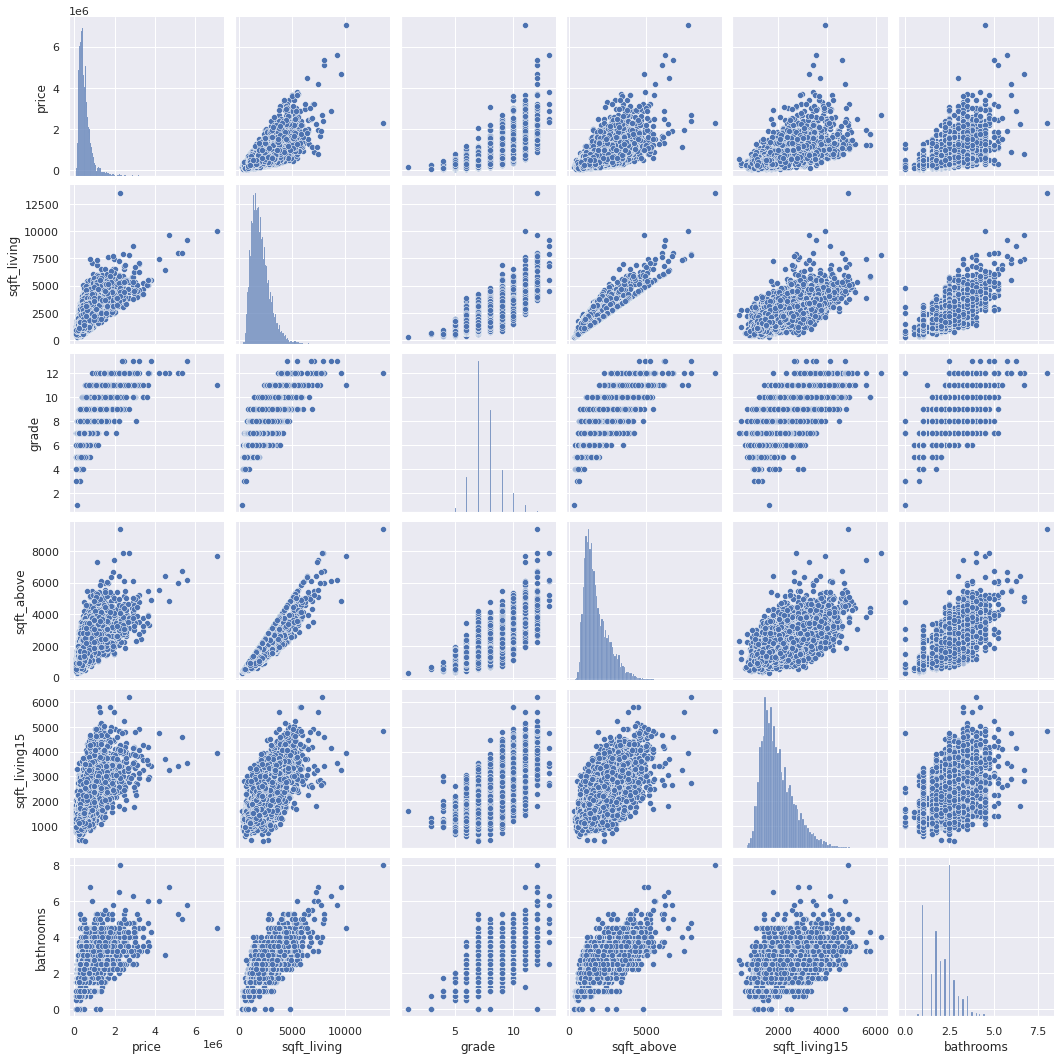

In [ ]:
sns.set()
cols = ['price','sqft_living','grade','sqft_above','sqft_living15','bathrooms']
sns.pairplot(data_train[cols], height = 2.5)
plt.show()

In [ ]:
#missing Data
total = data_train.isnull().sum().sort_values(ascending=False)
percent = (data_train.isnull().sum()/data_train.isnull().count().sort_values(ascending=False))
missing_data = pd.concat([total,percent],axis=1,keys=['Total','Percent'])
missing_data.head(20)

,Total,Percent
sqft_lot15,0,0.0
waterfront,0,0.0
price,0,0.0
sale_yr,0,0.0
sale_month,0,0.0
sale_day,0,0.0
bedrooms,0,0.0
bathrooms,0,0.0
sqft_living,0,0.0
sqft_lot,0,0.0


In [ ]:
print("the train data size before dropping id feature is:{}".format(data_train.shape))
print("the test data size before dropping id feature is:{}".format(data_test.shape))

the train data size before dropping id feature is:(12967, 23)
the test data size before dropping id feature is:(6485, 22)


In [ ]:
#ID備份
train_ID=data_train['id']
test_ID=data_test['id']


#刪除ID,因為ID沒有意義
data_train.drop('id',axis = 1,inplace=True)
data_test.drop('id',axis = 1,inplace=True)


#再次檢查Data大小
print("the train data size before dropping id feature is:{}".format(data_train.shape))
print("the test data size before dropping id feature is:{}".format(data_test.shape))

the train data size before dropping id feature is:(12967, 22)
the test data size before dropping id feature is:(6485, 21)


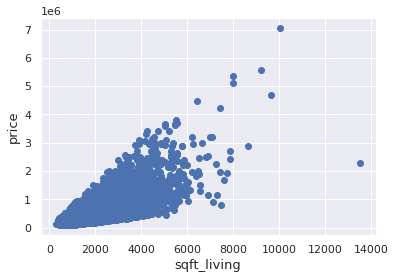

In [ ]:
plt.scatter(x=data_train['sqft_living'],y=data_train['price'])
plt.ylabel('price',fontsize=13)
plt.xlabel('sqft_living',fontsize=13)
plt.show()

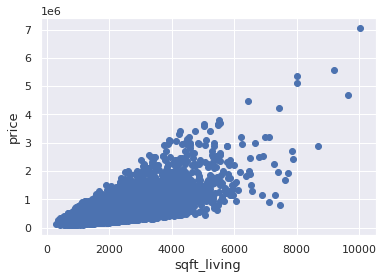

In [ ]:
#刪掉離群點
train =data_train.drop(data_train[(data_train['sqft_living']>12000) & (data_train['price']>8)].index)
plt.scatter(train['sqft_living'],train['price'])
plt.ylabel('price',fontsize=13)
plt.xlabel('sqft_living',fontsize=13)
plt.show()


 mu = 537248.89 and sigma = 366564.66



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'price distribution')

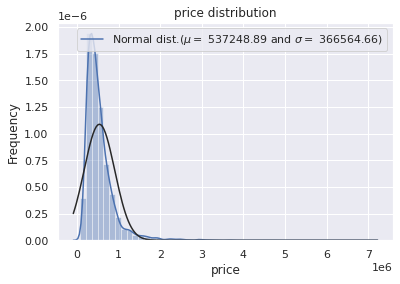

In [ ]:
#特徵

sns.distplot(train['price'],fit=norm)
(mu,sigma)=norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


#常態分布

plt.legend(['Normal dist.($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('price distribution')



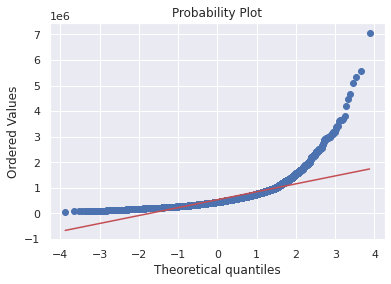

In [ ]:
#分位圖(QQ圖)
fig = plt.figure()
res = stats.probplot(train['price'],plot=plt)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 13.04 and sigma = 0.53



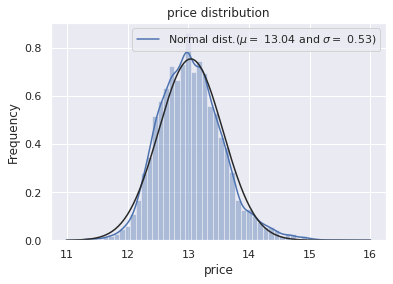

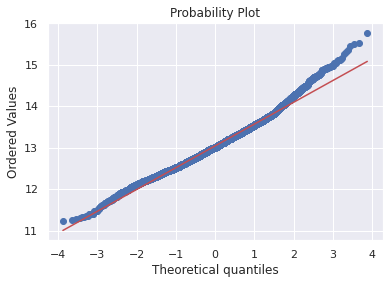

In [ ]:
#收斂

#對數變換log(1+x)
train['price'] = np.log1p(train['price'])

sns.distplot(train['price'],fit=norm);
(mu,sigma)=norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


#分布圖
plt.legend(['Normal dist.($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('price distribution')

#QQ圖
fig = plt.figure()
res = stats.probplot(train['price'],plot=plt)
plt.show()



In [ ]:
ntrain = train.shape[0]
ntest = data_test.shape[0]
y_train = train.price.values
all_data = pd.concat((train,data_test)).reset_index(drop=True)
all_data.drop(['price'],axis=1,inplace=True)
print("all_data size is:{}".format(all_data.shape))

all_data size is:(19451, 21)


In [ ]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na ==0].index).sort_values(ascending =False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio


In [ ]:
all_data.isnull().sum().max()


0

In [ ]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness.head(10)

,Skew
sqft_lot,13.013203
waterfront,11.332844
sqft_lot15,9.477361
yr_renovated,4.563642
view,3.395527
bedrooms,2.110127
sqft_basement,1.556271
sqft_above,1.420557
sqft_living,1.411504
sqft_living15,1.091933


In [ ]:
skewness = skewness[abs(skewness['Skew']) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    #all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 14 skewed numerical features to Box Cox transform


In [ ]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(19451, 21)


In [ ]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
lasso = Lasso(alpha=0.0005, random_state=1)


In [ ]:
ENet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)


In [ ]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)


In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [ ]:
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror',colsample_bytree=0.56, gamma=0.04, 
                             learning_rate=0.03, max_depth=7, 
                             min_child_weight=1, n_estimators=2200,
                             reg_alpha=0.4, reg_lambda=0.8,
                             subsample=0.7, silent=0,
                             random_state =7 )
# xgboost模型說明
#params = {
#    'booster':'gbtree',
#    'objective':'multi:softmax',   # 多分類問題
#    'num_class':10,          # 類別數，與multi softmax並用
#    'gamma':0.1,           # 用於控制是否后剪枝的參數，越大越保守，一般0.1 0.2的樣子
#    'max_depth':12,         # 構建樹的深度，越大越容易過擬合
#    'lambda':2,           # 控制模型復雜度的權重值的L2 正則化項參數，參數越大，模型越不容易過擬合
#    'subsample':0.7,         # 隨機采樣訓練樣本
#    'colsample_bytree':3,       # 這個參數默認為1，是每個葉子里面h的和至少是多少
                      # 對於正負樣本不均衡時的0-1分類而言，假設h在0.01附近，min_child_weight為1
                      #意味着葉子節點中最少需要包含100個樣本。這個參數非常影響結果，
                      # 控制葉子節點中二階導的和的最小值，該參數值越小，越容易過擬合

#    'silent':0,  # 設置成1 則沒有運行信息輸入，最好是設置成0
#    'eta':0.007,  # 如同學習率
#    'seed':1000,
#    'nthread':7,  #CPU線程數
    #'eval_metric':'auc'
#

In [ ]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1683 (0.0048)



In [ ]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))


In [ ]:
sub = pd.DataFrame()
sub['id'] = test_ID
sub['price'] = xgb_pred
sub.to_csv('submission001.csv',index=False)